In [32]:
from importlib import reload

import library

reload(library)
from library import *

env = init_env()

ModuleNotFoundError: No module named 'mlflow'

In [10]:
data_raw_rows = query_influxdb(env, """
from(bucket: "home_private")
  |> range(start: 2024-06-06T08:00:00.000Z, stop: 2024-10-25T03:00:00.000Z)
  |> filter(fn: (r) => r["entity_id"] == "weatherstation_console_battery_voltage")
  |> keep(columns: ["_time", "_value"])
""")

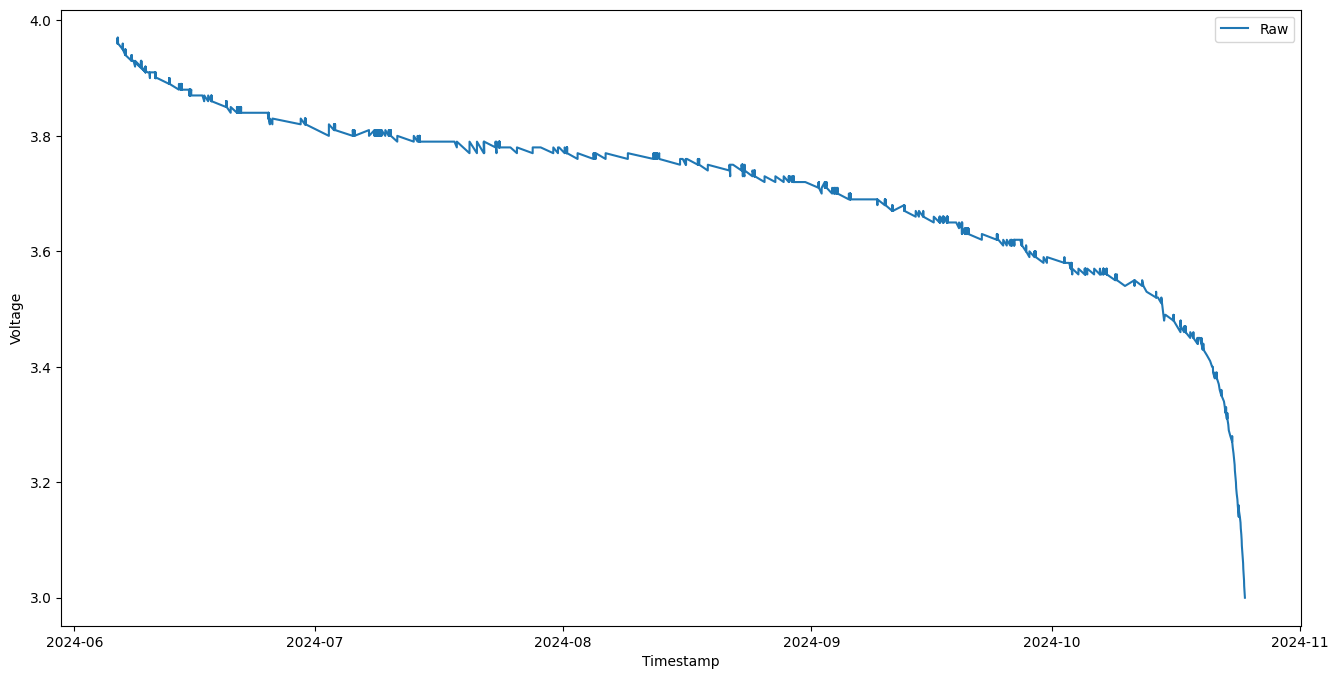

In [3]:
import polars as pl
from library import show_plot

data_raw_pl = pl.DataFrame(data_raw_rows, orient="row", schema={
    'Timestamp': pl.Datetime,
    'Voltage': pl.Float32
})
show_plot('Raw', data_raw_pl, 'Timestamp', 'Voltage')

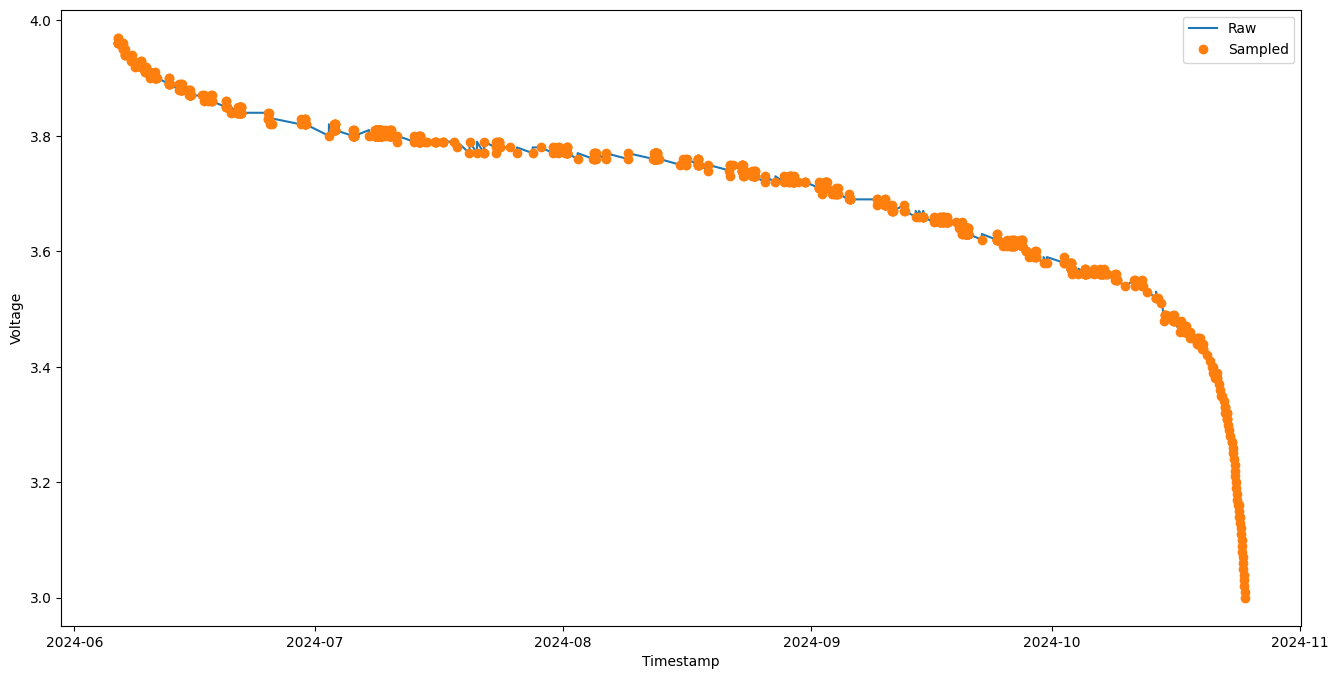

In [4]:
data_sampled_pl = data_raw_pl.sort('Timestamp').group_by_dynamic('Timestamp', every='10m').agg(pl.col('Voltage').min())
show_plot('Raw', data_raw_pl, 'Timestamp', 'Voltage')
show_plot('Sampled', data_sampled_pl, 'Timestamp', 'Voltage', 'o')

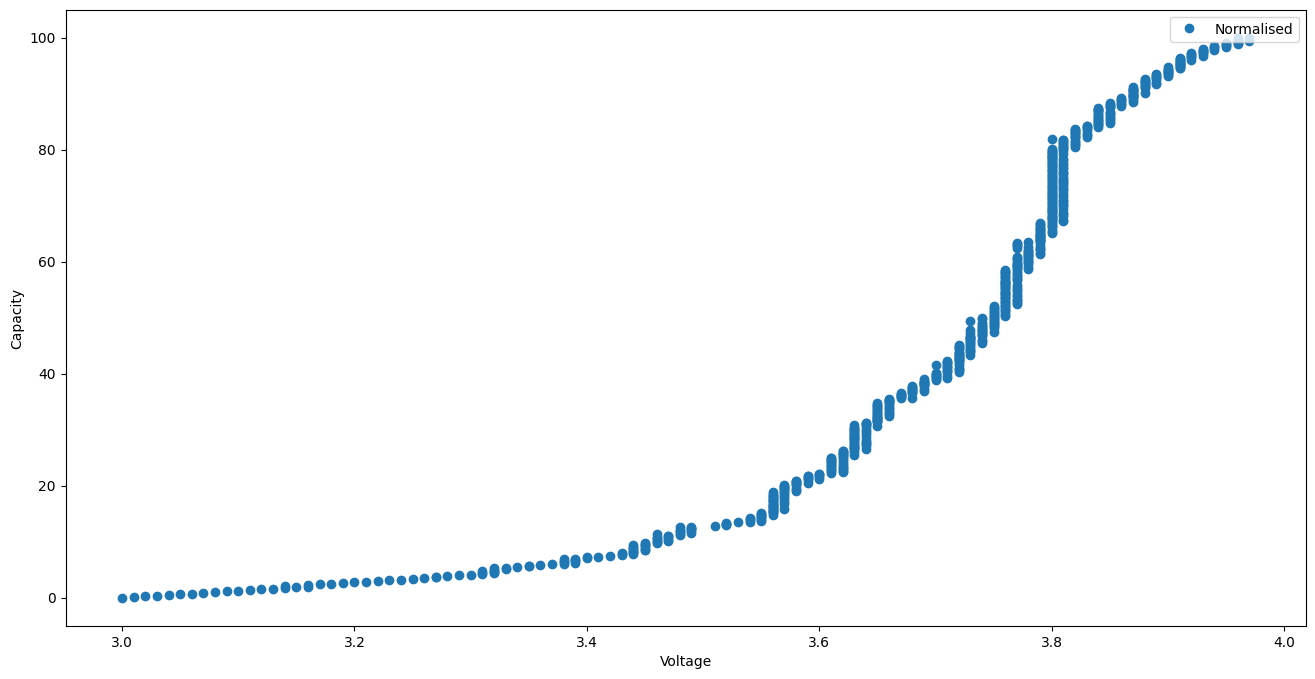

In [5]:
data_normalised_pl = data_sampled_pl.drop('Timestamp').with_row_index('Capacity')
data_normalised_pl = data_normalised_pl.with_columns((100 - pl.col('Capacity') / pl.max('Capacity') * 100).alias('Capacity'))
show_plot('Normalised', data_normalised_pl, 'Voltage', 'Capacity', 'o')


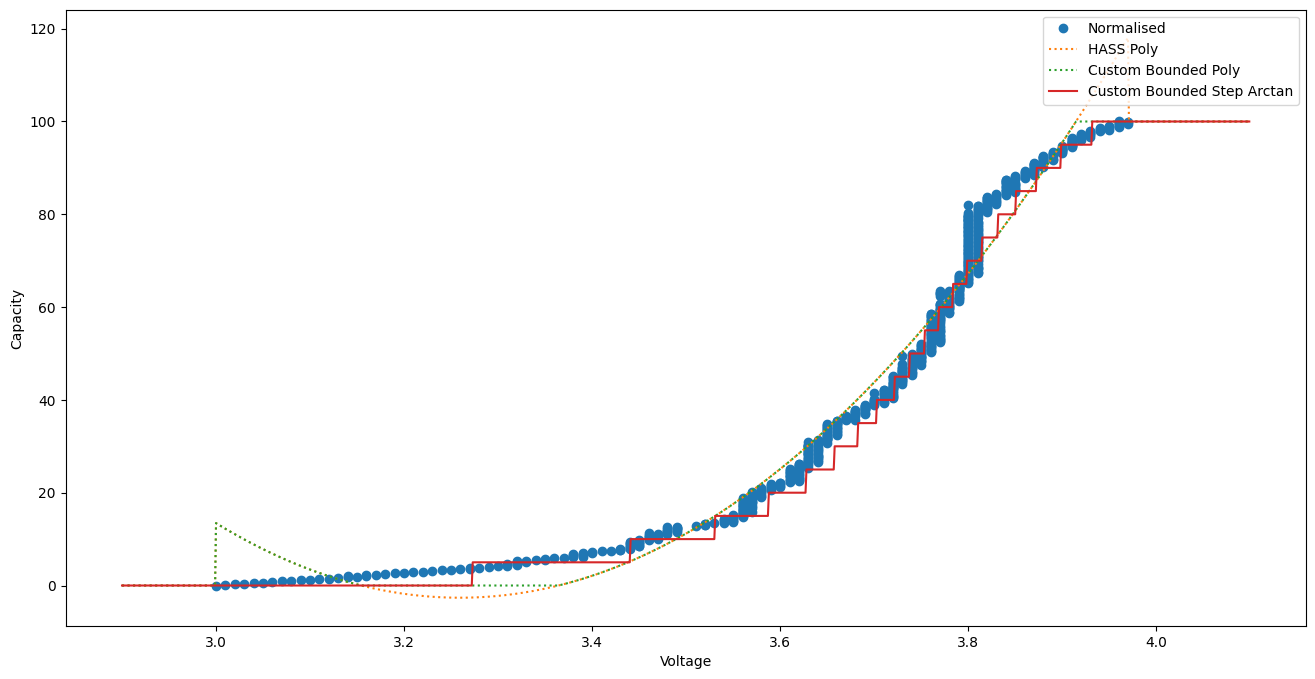

In [6]:
import numpy as np
from math import atan
from scipy.optimize import curve_fit

y_min = 0
y_max = 100
y_data = data_normalised_pl.select('Capacity').to_numpy().flatten()
x_min = data_normalised_pl.select(pl.min('Voltage')).item()
x_max = data_normalised_pl.select(pl.max('Voltage')).item()
x_data = data_normalised_pl.select('Voltage').to_numpy().flatten()

fit_poly_coefficients = np.polyfit(x_data, y_data, 2)
fit_poly_function = np.poly1d(fit_poly_coefficients)


def fit_hass_poly_function(x):
    if x < x_min:
        return y_min
    elif x > x_max:
        return y_max
    return fit_poly_function(x)


def fit_custom_bounded_poly_function(x):
    if x < x_min:
        return y_min
    elif x > x_max:
        return y_max
    y = fit_poly_function(x)
    if y < y_min:
        return y_min
    elif y > y_max:
        return y_max
    else:
        return y


def fit_custom_arctan(x, k, w, x0, y0):
    return k * np.arctan(w * (x - x0)) + y0


fit_arctan_coefficients = curve_fit(
    fit_custom_arctan, x_data, y_data, p0=[1, 1, 0.5 * (x_max + x_min), 0.5 * (y_max + y_min)], full_output=True)[0]


def fit_custom_bounded_arctan(x):
    if x < x_min:
        return y_min
    elif x > x_max:
        return y_max
    y = fit_arctan_coefficients[0] * atan(fit_arctan_coefficients[1] * (x - fit_arctan_coefficients[2])) + fit_arctan_coefficients[3]
    if y < y_min:
        return y_min
    elif y > y_max:
        return y_max
    else:
        return int(y) // 5 * 5


scale_factor = 1000
data_fitted_pl = pl.arange(2.9 * scale_factor, 4.1 * scale_factor, eager=True).to_frame('Voltage').with_columns(
    (pl.col("Voltage") / scale_factor))
data_fitted_hass_poly_pl = data_fitted_pl.with_columns(
    pl.col("Voltage").map_elements(lambda x: fit_hass_poly_function(x), return_dtype=pl.Float32).alias("Capacity"))
data_fitted_custom_bounded_poly_pl = data_fitted_pl.with_columns(
    pl.col("Voltage").map_elements(lambda x: fit_custom_bounded_poly_function(x), return_dtype=pl.Float32).alias("Capacity"))
data_fitted_custom_bounded_step_arctan_pl = data_fitted_pl.with_columns(
    pl.col("Voltage").map_elements(lambda x: fit_custom_bounded_arctan(x), return_dtype=pl.Float32).alias("Capacity"))

show_plot('Normalised', data_normalised_pl, 'Voltage', 'Capacity', 'o')
show_plot('HASS Poly', data_fitted_hass_poly_pl, 'Voltage', 'Capacity', ':')
show_plot('Custom Bounded Poly', data_fitted_custom_bounded_poly_pl, 'Voltage', 'Capacity', ':')
show_plot('Custom Bounded Step Arctan', data_fitted_custom_bounded_step_arctan_pl, 'Voltage', 'Capacity', '-')

In [7]:
print("""
#######################################################################################
# WARNING: This snippet is generated by mlflow/src/main/python/weatherstation/battery.ipynb
#######################################################################################

from math import atan


def _weatherstation_console_battery_voltage_to_capacity(_voltage):
    if _voltage < {}:
        return {}
    elif _voltage > {}:
        return {}
    _capacity = {} * atan({} * (_voltage - {})) + {}
    if _capacity < {}:
        return {}
    elif _capacity > {}:
        return {}
    else:
        return int(_capacity) // 5 * 5


#######################################################################################
    """.format(
    x_min,
    y_min,
    x_max,
    y_max,
    fit_arctan_coefficients[0],
    fit_arctan_coefficients[1],
    fit_arctan_coefficients[2],
    fit_arctan_coefficients[3],
    y_min,
    y_min,
    y_max,
    y_max,
))


#######################################################################################
# WARNING: This snippet is generated by mlflow/src/main/python/weatherstation/battery.ipynb
#######################################################################################

from math import atan


def _weatherstation_console_battery_voltage_to_capacity(_voltage):
    if _voltage < 3.0:
        return 0
    elif _voltage > 3.9700000286102295:
        return 100
    _capacity = 42.79797405269636 * atan(7.888389376782614 * (_voltage - 3.773066390128287)) + 61.61960792555436
    if _capacity < 0:
        return 0
    elif _capacity > 100:
        return 100
    else:
        return int(_capacity) // 5 * 5


#######################################################################################
    
